# Notebook test

## Create data in the folders

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import math
from tensorflow.keras.backend import expand_dims
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import os
import pandas as pd
import numpy as np

In [26]:
path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data')
path

'C:\\Users\\jmarc\\Documents\\code\\HeavenlyBodeep\\raw_data'

In [53]:
def create_set(path_origin, n_angle = 1):
    images=list(set([int(i[:-4]) for i in os.listdir(path) if i[-4:]==".png"]))
    mapping_train = {'picture_id':[], 'angle' :[]}
    mapping_val = {'picture_id':[], 'angle' :[]}
    mapping_test = {'picture_id':[], 'angle' :[]}
    train_path = os.path.join(path_origin, 'train_pictures')
    val_path = os.path.join(path_origin, 'val_pictures')
    test_path = os.path.join(path_origin, 'test_pictures')

    name = 0
    index = 0
    images = random.sample(images, len(images))
    for val,image in enumerate(images):
        print(os.path.join(path_origin, f'{image}.png'))
        if val/len(images) < 0.65:
            original_image = Image.open(os.path.join(path_origin, f'{image}.png'))
            for angle in range(n_angle):
                angle = np.random.uniform(0,360)
                rotated_image = original_image.rotate(angle).crop((710,290,1210,790)).resize((100,100))
                rotated_image.save(os.path.join(train_path, f'{index}.png'))
                mapping_train['picture_id'].append(index)
                mapping_train['angle'].append(angle)
                index += 1
        elif val/len(images) < 0.85:
            original_image = Image.open(os.path.join(path_origin, f'{image}.png'))
            angle = np.random.uniform(0,360)
            rotated_image = original_image.rotate(angle).crop((710,290,1210,790)).resize((100,100))
            rotated_image.save(os.path.join(val_path, f'{index}.png'))
            mapping_val['picture_id'].append(index)
            mapping_val['angle'].append(angle)
            index += 1
        else:
            original_image = Image.open(os.path.join(path_origin, f'{image}.png'))
            angle = np.random.uniform(0,360)
            rotated_image = original_image.rotate(angle).crop((710,290,1210,790)).resize((100,100))
            rotated_image.save(os.path.join(test_path, f'{index}.png'))
            mapping_test['picture_id'].append(index)
            mapping_test['angle'].append(angle)
            index += 1


    df_train = pd.DataFrame(mapping_train)
    df_train.to_csv(os.path.join(train_path,'train.csv'),index=False)
    df_val = pd.DataFrame(mapping_val)
    df_val.to_csv(os.path.join(val_path,'val.csv'),index=False)
    df_test = pd.DataFrame(mapping_test)
    df_test.to_csv(os.path.join(test_path,'test.csv'),index=False)
    
    return None

In [54]:
create_set(path, n_angle = 3)

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1072.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\756.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\916.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1028.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\990.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\795.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\490.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1144.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1163.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1065.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\143.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\894.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1168.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1243.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\43.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1030.png
C

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\598.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\349.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\834.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\738.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\333.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1175.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\504.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1331.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\625.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\307.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\421.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\463.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\565.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\447.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1410.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1142.png
C:\U

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\196.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1369.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\74.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\999.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\785.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1171.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\892.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\802.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\558.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\875.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1273.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\424.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\920.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\34.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1045.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\438.png
C:\Use

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\828.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1294.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\779.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\295.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\896.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\417.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\42.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\672.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1304.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\259.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\212.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\379.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1224.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\651.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\679.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\527.png
C:\Use

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1451.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\119.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1307.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\563.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\246.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\285.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\862.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\880.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\277.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1117.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1487.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\321.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1222.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\657.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\218.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1227.png
C:

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\786.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\52.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1317.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\380.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1332.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\539.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\759.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\737.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\405.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\294.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\494.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\140.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\511.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\483.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\503.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\237.png
C:\User

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\541.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1037.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\173.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\570.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1443.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1013.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\938.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1269.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1139.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1301.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\409.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\858.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\346.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\456.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1252.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\410.png
C

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\470.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1138.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\331.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1423.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\634.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\217.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\857.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\846.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1492.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1389.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1258.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1085.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\736.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\449.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\383.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\674.png
C:

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1146.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\791.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\177.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\269.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1328.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1432.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1119.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1353.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\530.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\626.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\29.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1505.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1248.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1373.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\219.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\85.png
C:

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\839.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1201.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\551.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\568.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\804.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1012.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1370.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1374.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\82.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\984.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\175.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1257.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\487.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1333.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\682.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\797.png
C:\

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\75.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1253.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1153.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\303.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\956.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\997.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1355.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1334.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\576.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\341.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\555.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1439.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\966.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\732.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\595.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1489.png
C:\

C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1200.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1386.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\849.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\597.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\363.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\844.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\710.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\304.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\317.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\155.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\726.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1057.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\215.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1044.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\1407.png
C:\Users\jmarc\Documents\code\HeavenlyBodeep\raw_data\25.png
C:\U

### Train data

## Data preparation

### Test data

In [7]:
def create_xy(path, set_part, method='sincos'):
    df = pd.read_csv(os.path.join(path, f'{set_part}_pictures', f'{set_part}.csv'))
    if method == 'sincos':
        df['cos'] = np.cos(df['angle']* np.pi / 180)
        df['sin'] = np.sin(df['angle']* np.pi / 180)
        y = np.array(df.drop(['angle', 'picture_id'], axis=1))
    else:
        df['angle'] = round(df['angle'],0).astype(int)
        y=np.array(df.drop(['picture_id'], axis=1).astype(str))[:,0]
    X = []
    X_index = list(df['picture_id'])
    name = 0
    for name in X_index:
        pic = Image.open(os.path.join(path, f'{set_part}_pictures', f'{name}.png'))
        X.append(np.array(pic)[:,:,0:3])
    X = np.array(X)
    return X, y

In [55]:
X_train, y_train = create_xy(path, 'train', method='sincos')

In [ ]:
y_train.shape

In [ ]:
y_val[0]

In [ ]:
plt.imshow(X_val[0])

In [56]:
X_test, y_test = create_xy(path, 'test')

In [57]:
X_val, y_val = create_xy(path, 'val')

## Modeling with regression layer

In [61]:
from tensorflow.keras import layers, models

reg_l1 = regularizers.L1(0.01)
adam = optimizers.Adam(learning_rate=0.0001)

model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=X_train[0].shape))
model.add(layers.Conv2D(16, (5,5), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(layers.Conv2D(64, (3,3), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(16, (3,3), padding='same', activation="relu"))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(8, (3,3), padding='same', activation="relu"))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu')) # intermediate layer - add : kernel_regularizer=reg_l1
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(128, activation='relu')) # intermediate layer - add : kernel_regularizer=reg_l1
model.add(layers.Dropout(rate=0.15))
model.add(layers.Dense(2, activation='linear'))

model.compile(loss='mse',
          optimizer=adam,
          metrics=['mse'])

In [62]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=4, min_lr=0.00001, min_delta=0.01)

In [63]:
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=200, callbacks=[es, reduce_lr])

Epoch 1/200
738/738 [==============================] - 23s 31ms/step - loss: 0.4975 - mse: 0.4975 - val_loss: 0.4587 - val_mse: 0.4587 - lr: 1.0000e-04
Epoch 2/200
738/738 [==============================] - 23s 32ms/step - loss: 0.4687 - mse: 0.4687 - val_loss: 0.4336 - val_mse: 0.4336 - lr: 1.0000e-04
Epoch 3/200
738/738 [==============================] - 23s 31ms/step - loss: 0.4513 - mse: 0.4513 - val_loss: 0.4201 - val_mse: 0.4201 - lr: 1.0000e-04
Epoch 4/200
738/738 [==============================] - 23s 32ms/step - loss: 0.4369 - mse: 0.4369 - val_loss: 0.4023 - val_mse: 0.4023 - lr: 1.0000e-04
Epoch 5/200
738/738 [==============================] - 23s 32ms/step - loss: 0.4183 - mse: 0.4183 - val_loss: 0.3826 - val_mse: 0.3826 - lr: 1.0000e-04
Epoch 6/200
738/738 [==============================] - 23s 31ms/step - loss: 0.3767 - mse: 0.3767 - val_loss: 0.3075 - val_mse: 0.3075 - lr: 1.0000e-04
Epoch 7/200
738/738 [==============================] - 23s 31ms/step - loss: 0.3260 - ms

In [107]:
model.save(os.path.join(os.path.dirname(os.getcwd()),'model.h5'), save_format='h5')

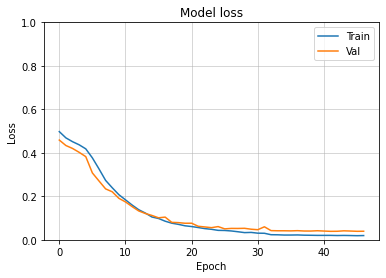

In [64]:
def plot_loss(history, title=None):
  
    # --- LOSS --- 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.ylim((0,1))
    plt.legend(['Train', 'Val'], loc='best')
    plt.grid(axis="x",linewidth=0.5)
    plt.grid(axis="y",linewidth=0.5)

plot_loss(history)

## Evaluation

In [65]:
model.evaluate(X_test,y_test)

8/8 [==============================] - 0s 25ms/step - loss: 0.0436 - mse: 0.0436


[0.04363026097416878, 0.04363026097416878]

In [66]:
y_pred = model.predict(X_test)

In [357]:
# predict_path = os.path.join(os.getcwd(), '..', 'raw_data', 'any_angle')

# img_predict = Image.open(os.path.join(predict_path, '2.png'))
# image = np.array(img_predict.crop((660,240,1260,840)).resize((64,64)))[:,:,0:3]

In [67]:
def angle(y_all):
    angle = []
    for y in y_all:
        angle2 = math.atan2(y[1], y[0])
        angle2 *= 180 / math.pi
        if angle2 < 0: angle2 += 360
        angle.append(angle2)
    return np.array(angle)

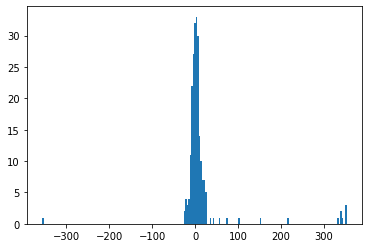

In [101]:
test_angle = angle(y_test)
pred_angle = angle(y_pred)
df = pd.DataFrame({'test_angle': angle(y_test), 'pred_angle': angle(y_pred)})
df['gap'] = df['test_angle'] - df['pred_angle']
plt.hist(x = df['gap'], bins=200);

In [97]:
y_pred.shape

(226, 2)

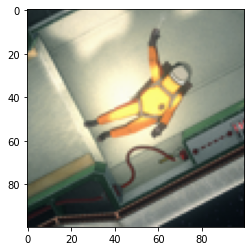

In [92]:
plt.imshow(X_test[1])

In [93]:
angle(expand_dims(y_test[1],0))

array([309.65837057])

In [94]:
angle(model.predict(expand_dims(X_test[1],0)))

array([310.03726188])

In [70]:
df['gap'][np.abs(df['gap']) < 300].std()

22.187026258770675

In [365]:
df.iloc[16,:]

test_angle    223.793179
pred_angle     19.407836
gap           204.385343
Name: 16, dtype: float64

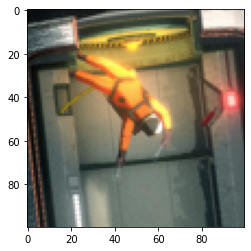

In [364]:
plt.imshow(X_test[16,:,:])

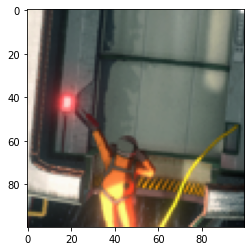

In [104]:
plt.imshow(X_test[79])

In [103]:
df.sort_values('gap').tail(10)

,test_angle,pred_angle,gap
17,116.898614,15.264708,101.633906
2,248.339757,97.453180,150.886578
79,359.018947,144.625835,214.393112
59,352.445522,18.294409,334.151113
214,359.580962,19.839522,339.741440
217,359.653420,18.717631,340.935790
160,348.352548,3.548015,344.804533
12,359.100125,10.149759,348.950366
90,353.485033,1.174735,352.310297
190,355.646594,3.212871,352.433722


34.62057622381567